<a href="https://colab.research.google.com/github/VictorHugofny/Redes-Neurais-Python/blob/main/codigoaula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('aeronave', 'carro', 'passaro', 'gato',
           'veado', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhao')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img): 
    img = (img * 0.5) + 0.5  # desnormalizar imagens
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

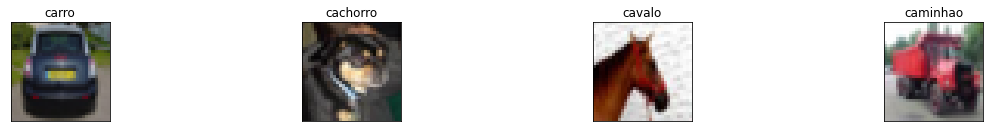

In [4]:
import numpy as np
# Um batch de dados de treino
dataiter = iter(trainloader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 8/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,...)                                  
        self.pool = nn.MaxPool2d(2, 2)    # MaxPool2d(kernel_size, stride=None, padding=0, ...)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn = CNN()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [25]:
epochs = 4
for epoch in range(epochs):  
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zera os gradientes de todas as variaveis
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels) # calcula loss da batch
        loss.backward() # Computa o gradiente da loss com relação aos parametros do modelo
        optimizer.step() # Update dos parametros

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # para cada  mini-batches de 2000
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.065
[1,  4000] loss: 1.040
[1,  6000] loss: 1.042
[1,  8000] loss: 1.039
[1, 10000] loss: 1.051
[1, 12000] loss: 1.047
[2,  2000] loss: 1.053
[2,  4000] loss: 1.029
[2,  6000] loss: 1.045
[2,  8000] loss: 1.051
[2, 10000] loss: 1.059
[2, 12000] loss: 1.038
[3,  2000] loss: 1.057
[3,  4000] loss: 1.031
[3,  6000] loss: 1.061
[3,  8000] loss: 1.046
[3, 10000] loss: 1.028
[3, 12000] loss: 1.070
[4,  2000] loss: 1.037
[4,  4000] loss: 1.063
[4,  6000] loss: 1.050
[4,  8000] loss: 1.038
[4, 10000] loss: 1.047
[4, 12000] loss: 1.046
Finished Training


In [8]:
import os
model_path = './model/'
file_name = 'cnn_model.pth'

if not os.path.exists(model_path): 
        os.makedirs(model_path)
        
torch.save(cnn.state_dict(), model_path + file_name) 

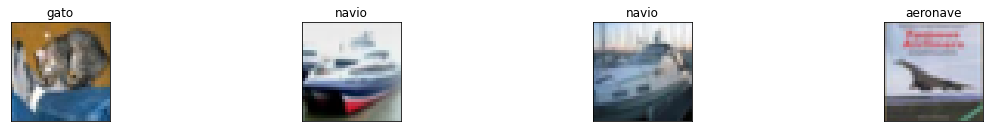

In [31]:
# Um batch de dados de teste
dataiter = iter(testloader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 8/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [24]:
cnn = CNN()
cnn.load_state_dict(torch.load(model_path + file_name))

<All keys matched successfully>

In [21]:
outputs = cnn(images)
outputs

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   gato navio navio aeronave


In [22]:
correct = 0
total = 0
# nao precisamos calcular os valores de gradiente pq não estamos treinando
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [23]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        _, predictions = torch.max(outputs, 1)
        # calcula predições corretas para cada classe
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print acurácia para cada classe
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class aeronave is: 68.9 %
Accuracy for class carro is: 74.0 %
Accuracy for class passaro is: 46.9 %
Accuracy for class gato  is: 31.7 %
Accuracy for class veado is: 41.3 %
Accuracy for class cachorro is: 53.1 %
Accuracy for class sapo  is: 78.9 %
Accuracy for class cavalo is: 74.6 %
Accuracy for class navio is: 70.6 %
Accuracy for class caminhao is: 58.9 %
